# Agent Chat with Multi-Modality Models

We use **LLaVA** as an example for the multi-modality feature.  More information about LLaVA can be found in their [GitHub page](https://github.com/haotian-liu/LLaVA)


This notebook contains the following information and examples:

1. Setup LLaVA 
    - Option 1: Use API calls from `Replicate`
    - Option 2: Setup LLaVA locally (requires GPU)
2. Application 1: Garden helper
3. Application 2: Figure Creator

In [1]:
# We use this variable to control where you want to host LLaVA, locally or remotely?
# More details in the two setup options below.
LLAVA_MODE = "remote" # Either "local" or "remote"
assert LLAVA_MODE in ["local", "remote"]

In [2]:
# we will override the following variables later.
MODEL_NAME = "" 
SEP = "###"

## Install the LLaVA library

Please follow the LLaVA GitHub [page](https://github.com/haotian-liu/LLaVA/) to install LLaVA.


#### Download the package
git clone https://github.com/haotian-liu/LLaVA.git
cd LLaVA

#### Install the inference package
conda create -n llava python=3.10 -y
conda activate llava
pip install --upgrade pip  # enable PEP 660 support
pip install -e .


In [3]:
import requests
import json
import os
from llava.conversation import default_conversation as conv
from llava.conversation import Conversation

[2023-10-19 12:58:15,654] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


# (Option 1, preferred) Use API Calls from Replicate [Remote]
We can also use [Replicate](https://replicate.com/yorickvp/llava-13b/api) to use LLaVA directly, which will host the model for you.

1. Run `pip install replicate` to install the package
2. You need to get an API key from Replicate from your [account setting page](https://replicate.com/account/api-tokens)
3. Next, copy your API token and authenticate by setting it as an environment variable:
    `export REPLICATE_API_TOKEN=<paste-your-token-here>` 
4. You need to enter your credit card information for Replicate 🥲
    

In [4]:
# pip install replicate
# import os
## alternatively, you can put your API key here for the environment variable.
# os.environ["REPLICATE_API_TOKEN"] = "r8_xyz your api key goes here~"

In [5]:
if LLAVA_MODE == "remote":
    import replicate

## [Option 2] Setup LLaVA Locally


Some helpful packages and dependencies:
```bash
conda install -c nvidia cuda-toolkit
```


### Launch

In one terminal, start the controller first:
```bash
python -m llava.serve.controller --host 0.0.0.0 --port 10000
```


Then, in another terminal, start the worker, which will load the model to the GPU:
```bash
python -m llava.serve.model_worker --host 0.0.0.0 --controller http://localhost:10000 --port 40000 --worker http://localhost:40000 --model-path liuhaotian/llava-v1.5-13b
``

**Note: make sure the environment of this notebook also installed the llava package from `pip install -e .`**

In [6]:
# Run this code block only if you want to run LlaVA locally
if LLAVA_MODE == "local":
    # Setup some global constants for convenience
    # Note: make sure the addresses below are consistent with your setup in LLaVA 
    CONTROLLER_ADDR = "http://0.0.0.0:10000"
    SEP =  conv.sep
    ret = requests.post(CONTROLLER_ADDR + "/list_models")
    print(ret.json())
    MODEL_NAME = ret.json()["models"][0]
    print("Model Name:", MODEL_NAME)

# Multi-Modal Functions

The Multi-Modal Functions library provides a set of utilities to manage and process multi-modal data, focusing on textual and image components. The library allows you to format prompts, extract image paths, and handle image data in various formats.

## Functions


### `get_image_data`

This function retrieves the content of an image specified by a file path or URL and optionally converts it to base64 format. It can handle both web-hosted images and locally stored files.


### `lmm_formater`

This function formats a user-provided prompt containing `<img ...>` tags, replacing these tags with `<image>` or numbered versions like `<image 1>`, `<image 2>`, etc., and extracts the image locations. It returns a tuple containing the new formatted prompt and a list of image data.

In [7]:
import base64
import re
from io import BytesIO

from PIL import Image

import re
from typing import List, Tuple


def get_image_data(image_file, use_b64=True):
    if image_file.startswith('http://') or image_file.startswith('https://'):
        response = requests.get(image_file)
        content = response.content
    elif re.match(r"data:image/(?:png|jpeg);base64,", image_file):
        return re.sub(r"data:image/(?:png|jpeg);base64,", "", image_file)
    else:
        image = Image.open(image_file).convert('RGB')
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        content = buffered.getvalue()
        
    if use_b64:
        return base64.b64encode(content).decode('utf-8')
    else:
        return content

def lmm_formater(prompt: str, order_image_tokens: bool = False) -> Tuple[str, List[str]]:
    """
    Formats the input prompt by replacing image tags and returns the new prompt along with image locations.
    
    Parameters:
        - prompt (str): The input string that may contain image tags like <img ...>.
        - order_image_tokens (bool, optional): Whether to order the image tokens with numbers. 
            It will be useful for GPT-4V. Defaults to False.
    
    Returns:
        - Tuple[str, List[str]]: A tuple containing the formatted string and a list of images (loaded in b64 format).
    """
    
    # Initialize variables
    new_prompt = prompt
    image_locations = []
    images = []
    image_count = 0
    
    # Regular expression pattern for matching <img ...> tags
    img_tag_pattern = re.compile(r'<img ([^>]+)>')
    
    # Find all image tags
    for match in img_tag_pattern.finditer(prompt):
        image_location = match.group(1)
        
        try: 
            img_data = get_image_data(image_location)
        except:
            # Remove the token
            print(f"Warning! Unable to load image from {image_location}")
            new_prompt = new_prompt.replace(match.group(0), "", 1)
            continue
        
        image_locations.append(image_location)
        images.append(img_data)
        
        # Increment the image count and replace the tag in the prompt
        new_token = f'<image {image_count}>' if  order_image_tokens else "<image>"

        new_prompt = new_prompt.replace(match.group(0), new_token, 1)
        image_count += 1
        
    return new_prompt, images


def extract_img_paths(paragraph: str) -> list:
    """
    Extract image paths (URLs or local paths) from a text paragraph.
    
    Parameters:
        paragraph (str): The input text paragraph.
        
    Returns:
        list: A list of extracted image paths.
    """
    # Regular expression to match image URLs and file paths
    img_path_pattern = re.compile(r'\b(?:http[s]?://\S+\.(?:jpg|jpeg|png|gif|bmp)|\S+\.(?:jpg|jpeg|png|gif|bmp))\b', 
                                  re.IGNORECASE)
    
    # Find all matches in the paragraph
    img_paths = re.findall(img_path_pattern, paragraph)
    return img_paths


def _to_pil(data):
    return Image.open(BytesIO(base64.b64decode(data)))


def llava_call(prompt:str, model_name: str=MODEL_NAME, images: list=[], 
               max_new_tokens:int=1000, temperature: float=0.5, seed: int = 1) -> str:
    """
    Makes a call to the LLaVA service to generate text based on a given prompt and optionally provided images.

    Args:
        - prompt (str): The input text for the model. Any image paths or placeholders in the text should be replaced with "<image>".
        - model_name (str, optional): The name of the model to use for the text generation. Defaults to the global constant MODEL_NAME.
        - images (list, optional): A list of image paths or URLs. If not provided, they will be extracted from the prompt.
            If provided, they will be appended to the prompt with the "<image>" placeholder.
        - max_new_tokens (int, optional): Maximum number of new tokens to generate. Defaults to 1000.
        - temperature (float, optional): temperature for the model. Defaults to 0.5.

    Returns:
        - str: Generated text from the model.

    Raises:
        - AssertionError: If the number of "<image>" tokens in the prompt and the number of provided images do not match.
        - RunTimeError: If any of the provided images is empty.

    Notes:
    - The function uses global constants: CONTROLLER_ADDR and SEP.
    - Any image paths or URLs in the prompt are automatically replaced with the "<image>" token.
    - If more images are provided than there are "<image>" tokens in the prompt, the extra tokens are appended to the end of the prompt.
    """
    # TODO 1: add caching around the LLaVA call to save compute and cost
    # TODO 2: add `seed` to ensure reproducibility. The seed is not working now.
    if len(images) == 0:
        prompt, images = lmm_formater(prompt, order_image_tokens=False)
    else:
        # Append the <image> token if missing
        assert prompt.count("<image>") <= len(images), "the number "
        "of image token in prompt and in the images list should be the same!"
        num_token_missing = len(images) - prompt.count("<image>")
        prompt += " <image> " * num_token_missing
        images = [get_image_data(x) for x in images]
    
    for im in images:
        if len(im) == 0:
            raise RunTimeError("An image is empty!")

    if LLAVA_MODE == "local":
        headers = {"User-Agent": "LLaVA Client"}
        pload = {
            "model": model_name,
            "prompt": prompt,
            "max_new_tokens": max_new_tokens,
            "temperature": temperature,
            "stop": SEP,
            "images": images,
        }

        response = requests.post(CONTROLLER_ADDR + "/worker_generate_stream", headers=headers,
                json=pload, stream=False)

        for chunk in response.iter_lines(chunk_size=8192, decode_unicode=False, delimiter=b"\0"):
            if chunk:
                data = json.loads(chunk.decode("utf-8"))
                output = data["text"].split(SEP)[-1]
    elif LLAVA_MODE == "remote":
        # The Replicate version of the model only support 1 image for now.
        img = 'data:image/jpeg;base64,' + images[0]
        response = replicate.run(
            "yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
            input={"image": img, "prompt": prompt.replace("<image>", " "), "seed": seed}
        )
        # The yorickvp/llava-13b model can stream output as it's running.
        # The predict method returns an iterator, and you can iterate over that output.
        output = ""
        for item in response:
            # https://replicate.com/yorickvp/llava-13b/versions/2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591/api#output-schema
            output += item
        
    # Remove the prompt and the space.
    output = output.replace(prompt, "").strip().rstrip()
    
    return output


Here is the image that we are going to use.

![Image](https://github.com/haotian-liu/LLaVA/raw/main/images/llava_logo.png)

We can call llava by providing the prompt and images separately.


In [8]:
out = llava_call("Describe this image: <image>", 
                 images=["https://github.com/haotian-liu/LLaVA/raw/main/images/llava_logo.png"])
print(out)

The image features a small, red toy animal, possibly a stuffed animal or a figurine, with flames coming out of its back. The toy is positioned on a table, and it appears to be a unique and eye-catching design. The toy is wearing glasses, adding to its distinctive appearance. The flames on the toy's back create a sense of motion and energy, making it an interesting and playful addition to the scene.


Or, we can also call LLaVA with only prompt, with images embedded in the prompt with the <img xxx> format


In [9]:
out = llava_call("Describe this image in one sentence: <img https://github.com/haotian-liu/LLaVA/raw/main/images/llava_logo.png>")
print(out)

A red toy with flames and glasses on it.


## Application 1: Garden Helper

In this section, we present a straightforward dual-agent architecture aimed at facilitating garden management.

We identified an issue in our garden and captured it in the following photograph:
![](http://th.bing.com/th/id/R.105d684e5df7d540e61f6300d0bd374e?rik=PR8LCyvpe93DZA&pid=ImgRaw&r=0)



In [10]:
# Import AutoGen and setup the LLaVAAgent
import autogen
from autogen import AssistantAgent, Agent, UserProxyAgent
from termcolor import colored
import random

config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

llm_config = {"config_list": config_list_gpt4, "seed": 42}



class LLaVAAgent(AssistantAgent):
    def __init__(self, img_str_format=None, **kwargs):
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=LLaVAAgent._image_reply, position=0)
        self._img_str_format = img_str_format

    def _image_reply(
        self,
        messages=None,
        sender=None, config=None
    ):
        # Note: we did not use "llm_config" yet.
        # TODO 1: make the LLaVA API design compatible with llm_config
        # TODO 2: the `_image_reply` function should handle input prompt
        #         differently for different `img_str_format`, which will
        #         be valueable for different LMMs.
        # TODO 3: handle the memory and store image data in the memory.
        
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        # The formats for LLaVA and GPT are different. So, we manually handle them here.
        # TODO: format the images from the history accordingly.
        prompt = self.system_message
        for msg in messages:
            role = "Human" if msg["role"] == "user" else "Assistant"
            content = msg["content"]
            prompt += f"{SEP}{role}: {content}"
        prompt += SEP
        print(colored(prompt, "blue"))
    
        out = ""
        retry = 10
        while len(out) == 0 and retry > 0:
            # image names will be inferred automatically from llava_call
            out = llava_call(prompt=prompt, temperature=0, max_new_tokens=2000)
            retry -= 1
            
        assert out != "", "Empty response from LLaVA."
        
        
        return True, out

Within the user proxy agent, we can decide to activate the human input mode or not (for here, we use human_input_mode="NEVER" for conciseness). This allows you to interact with LLaVA in a multi-round dialogue, enabling you to provide feedback as the conversation unfolds.

In [11]:
image_agent = LLaVAAgent(
    name="image-explainer",
    system_message="You are a garden helper. You should describe the image and provide suggestions for the garden.",
    max_consecutive_auto_reply=0
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "groupchat"
    },
    human_input_mode="NEVER", # Try between ALWAYS or NEVER
    llm_config=llm_config,
    max_consecutive_auto_reply=0,
)

# Ask the question with an image
user_proxy.initiate_chat(image_agent, 
                         message="Here is my image: <img http://th.bing.com/th/id/R.105d684e5df7d540e61f6300d0bd374e?rik=PR8LCyvpe93DZA&pid=ImgRaw&r=0>. Can you give me some suggestions?")


User_proxy (to image-explainer):

Here is my image: <img http://th.bing.com/th/id/R.105d684e5df7d540e61f6300d0bd374e?rik=PR8LCyvpe93DZA&pid=ImgRaw&r=0>. Can you give me some suggestions?

--------------------------------------------------------------------------------
You are a garden helper. You should describe the image and provide suggestions for the garden.###Human: Here is my image: <img http://th.bing.com/th/id/R.105d684e5df7d540e61f6300d0bd374e?rik=PR8LCyvpe93DZA&pid=ImgRaw&r=0>. Can you give me some suggestions?###
image-explainer (to User_proxy):

In the image, there are several strawberries growing on a plant, with some of them still attached to their leaves. The strawberries are in various stages of ripeness, with some appearing to be ripe and ready to be picked, while others are still green and unripe. The plant is surrounded by other plants, including a pineapple plant, which is also growing nearby.

To maintain and improve the garden, the following suggestions can be cons

# Application 2: Figure Creator

Here, we define a `FigureCreator` agent, which contains three child agents: commander, coder, and critics.

- Commander: interacts with users, runs code, and coordinates the flow between the coder and critics.
- Coder: writes code for visualization.
- Critics: LLaVA-based agent that provides comments and feedback on the generated image.

In [12]:
class FigureCreator(AssistantAgent):

    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a FigureCreator instance.
        
        This agent facilitates the creation of visualizations through a collaborative effort among its child agents: commander, coder, and critics.
        
        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None],
                            reply_func=FigureCreator._reply_user,
                            position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)
            raise AssertionError(error_msg)

        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        ### Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message=
            "Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip().endswith(
                "TERMINATE"),
            code_execution_config={
                "last_n_messages": 3,
                "work_dir": ".",
                "use_docker": False
            },
            llm_config=self.llm_config,
        )

        critics = LLaVAAgent(
            name="Critics",
            system_message=
            "Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure. If you think the figures is good enough, then simply say NO_ISSUES",
            llm_config=self.llm_config,
            human_input_mode="NEVER",
            max_consecutive_auto_reply=0,
            #     use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message +
            "ALWAYS save the figure in `result.jpg` file. Tell other agents it is in the <img result.jpg> file location."
        )

        # Data flow begins
        commander.initiate_chat(coder, message=user_question)
        img = Image.open("result.jpg")
        plt.imshow(img)
        plt.axis('off')  # Hide the axes
        plt.show()
        
        for i in range(self._n_iters):
            commander.send(message="Improve <img result.jpg>",
                           recipient=critics,
                           request_reply=True)
            
            feedback = commander._oai_messages[critics][-1]["content"]
            if feedback.find("NO_ISSUES") >= 0:
                break
            commander.send(
                message="Here is the feedback to your figure. Please improve! Save the result to `result.jpg`\n"
                + feedback,
                recipient=coder,
                request_reply=True)
            critics.clear_history(commander)
            img = Image.open("result.jpg")
            plt.imshow(img)
            plt.axis('off')  # Hide the axes
            plt.show()
            
        return True, "result.jpg"

User (to Figure Creator~):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Coder (to Commander):

To plot the figure using the data from the provided URL, we'll first download the data, then use the pandas library to read the CSV data and finally, use the matplotlib library to plot the temperature high and low.

Step 1: Download the CSV file
Step 2: Read the CSV file using pandas
Step 3: Plot the temperature high and low using matplotlib

Please execute the following code:

```python
import pandas as pd
import matplotlib.p

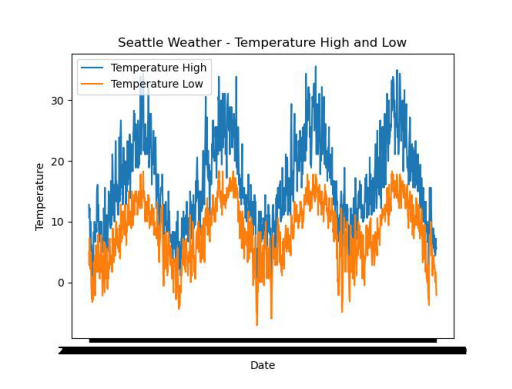

Commander (to Critics):

Improve <img result.jpg>

--------------------------------------------------------------------------------
Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure. If you think the figures is good enough, then simply say NO_ISSUES###Human: Improve <img result.jpg>###
Critics (to Commander):

The input figure is a graph showing the temperature in Seattle, with three different temperature ranges: high, low, and temperature high and low. The graph is color-coded, with blue representing temperature high, orange representing temperature low, and the rest of the colors representing the temperature range between high and low.

One issue with the figure is that it is not clear which temperature range corresponds to which color. It would be helpful to include labels or annotations on the graph to indicate the temperature ranges associated with each color. Additionally, the graph could be improved by adding a title o

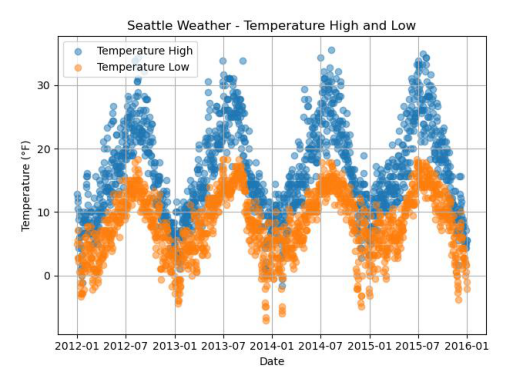

Commander (to Critics):

Improve <img result.jpg>

--------------------------------------------------------------------------------
Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure. If you think the figures is good enough, then simply say NO_ISSUES###Human: Improve <img result.jpg>###
Critics (to Commander):

The input figure is a graph showing temperature highs and lows for Seattle, Washington. The graph has a few issues that can be improved:

1. The x-axis labels are missing, which makes it difficult to understand the time scale of the graph. Adding the month names or year numbers would help in identifying the specific time period.
2. The graph is not clearly labeled with the title "Seattle Weather - Temperature High and Low." Adding a title to the graph would make it more informative and easier to understand.
3. The graph is not well-organized, and the temperature highs and lows are not clearly distinguished. Separating t

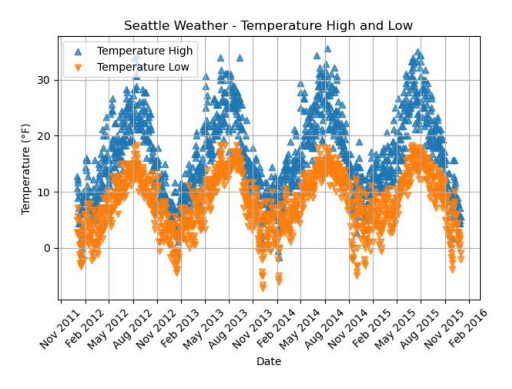

Figure Creator~ (to User):

result.jpg

--------------------------------------------------------------------------------


In [14]:
import matplotlib.pyplot as plt
import time

creator = FigureCreator(
    name="Figure Creator~",
    llm_config=llm_config
    
)

user_proxy = autogen.UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    llm_config=llm_config,
    max_consecutive_auto_reply=0
)

user_proxy.initiate_chat(creator, message="""
Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.
""")
